# Bitcoin Trading mit DQN: Training & Testen

Dieses Notebook demonstriert ein Bitcoin Trading Environment, in dem ein DQN-Agent auf historischen Daten trainiert wird und anschließend eine Trading-Strategie entwickelt. Dabei werden:

- **Training:** Daten aus dem Zeitraum 2015 bis 2020 verwendet.
- **Test:** Daten aus dem Zeitraum 2021 bis 2025 genutzt.

Das Portfolio startet als Multiplikator bei 1.0 (d. h. ein Wert von 1.2 entspricht +20% Gewinn, 0.8 entspricht -20% Verlust). Außerdem wird der Trading-Verlauf gegen eine Buy-and-Hold-Strategie in einem logarithmisch skalierten Diagramm (mit Datumsangaben) verglichen.


In [5]:
%matplotlib inline

import gym
import numpy as np
import pandas as pd
import yfinance as yf
from gym import spaces
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import warnings

warnings.filterwarnings("ignore")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


## Environment-Definition

Das Environment `BitcoinTradingEnv`:
- Lädt historische Bitcoin-Daten und filtert diese anhand eines übergebenen Datumsbereichs.
- Nutzt ein Fenster (window_size) der skalierten Daten als Beobachtung, ergänzt durch den Positionsstatus und den aktuellen Portfolio-Multiplikator.
- Berechnet den Reward basierend auf der Änderung des Portfolio-Multiplikators.
- Beim Rendern und Plotten wird das aktuelle Datum angezeigt.

Im Plot wird der Verlauf des Trading-Portfolios mit einer Buy-and-Hold-Strategie (logarithmische y-Achse) verglichen.


In [2]:
class BitcoinTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, window_size=30, initial_capital=1.0,
                 overall_start_date='2014-09-17', overall_end_date='2025-12-31',
                 date_range=None):
        super(BitcoinTradingEnv, self).__init__()
        self.window_size = window_size
        self.initial_capital = initial_capital
        
        # Lade historische Bitcoin-Daten
        self.df = yf.download('BTC-USD', start=overall_start_date, end=overall_end_date)
        self.df.columns = self.df.columns.get_level_values(0)
        # Filtere Daten anhand des angegebenen Datumsbereichs (z. B. Training oder Test)
        if date_range is not None:
            self.df = self.df.loc[date_range[0]:date_range[1]]
            
        self.data = self.df[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
        self.num_features = self.data.shape[1]
        
        # Skaliere die Features in den Bereich [0, 1]
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaled_features = self.scaler.fit_transform(self.data.values)
        self.close_prices = self.df['Close'].values
        
        # Aktionsraum: 0 = Halten, 1 = Kaufen, 2 = Verkaufen
        self.action_space = spaces.Discrete(3)
        # Beobachtungsraum: window, position und portfolio (Multiplikator)
        self.observation_space = spaces.Dict({
            'window': spaces.Box(low=0, high=1, shape=(self.window_size, self.num_features), dtype=np.float32),
            'position': spaces.Discrete(2),
            'portfolio': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)
        })
        self.reset()
    
    def reset(self):
        self.current_step = self.window_size  # Beginne, wenn ein vollständiges Fenster vorliegt
        self.portfolio = self.initial_capital    # Startwert = 1.0
        self.position = 0  # 0 = nicht investiert, 1 = investiert
        self.buy_price = None
        self.portfolio_history = [self.portfolio]
        return self._get_observation()
    
    def _get_observation(self):
        return {
            'window': self.scaled_features[self.current_step - self.window_size : self.current_step].astype(np.float32),
            'position': self.position,
            'portfolio': np.array([self.portfolio], dtype=np.float32)
        }
    
    def step(self, action):
        done = False
        reward = 0
        penalty = 10
        
        # Wenn das Ende der Daten erreicht ist
        if self.current_step >= len(self.scaled_features) - 1:
            done = True
            return self._get_observation(), reward, done, {}
        
        prev_price = self.close_prices[self.current_step - 1]
        current_price = self.close_prices[self.current_step]
        prev_portfolio = self.portfolio
        
        if self.position == 1:
            self.portfolio *= (current_price / prev_price)
            
        if action == 1:  # Kaufen
            if self.position == 0:
                self.position = 1
                self.buy_price = current_price
            else:
                reward -= penalty
        elif action == 2:  # Verkaufen
            if self.position == 1:
                self.position = 0
                self.buy_price = None
            else:
                reward -= penalty
        elif action == 0:  # Halten
            pass
        else:
            raise ValueError("Ungültige Aktion")
        
        reward += self.portfolio - prev_portfolio
        
        self.current_step += 1
        self.portfolio_history.append(self.portfolio)
        if self.current_step >= len(self.scaled_features) - 1:
            done = True
        
        return self._get_observation(), reward, done, {}
    
    def render(self, mode='human'):
        date = self.df.index[self.current_step].strftime("%Y-%m-%d")
        status = "Invested" if self.position == 1 else "Not invested"
        current_price = self.close_prices[self.current_step]
        print(f"Date: {date} | Portfolio: {self.portfolio:.4f} | Position: {status} | Price: {current_price:.2f}")
    
    def plot_comparison_log(self):
        # Buy-and-Hold: ab dem Start der Episode investiert und bis zum Ende gehalten
        initial_index = self.window_size  
        initial_price = self.close_prices[initial_index]
        buy_and_hold = [
            self.initial_capital * (self.close_prices[initial_index + i] / initial_price)
            for i in range(len(self.portfolio_history))
        ]
        dates = self.df.index[self.window_size:self.window_size + len(self.portfolio_history)]
        plt.figure(figsize=(10, 5))
        plt.plot(dates, self.portfolio_history, label="Trading Portfolio")
        plt.plot(dates, buy_and_hold, label="Buy and Hold Portfolio", linestyle="--")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Multiplier")
        plt.title("Trading vs. Buy and Hold (Log Scale)")
        plt.yscale("log")
        plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter())
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.show()


## DQN-Agent und Replay Buffer

Der Agent besteht aus einem einfachen Feedforward-Netzwerk (`QNetwork`), das die Q-Werte approximiert.  
Mit einem Replay Buffer werden Erfahrungen gespeichert und in Batches zum Training verwendet.


In [3]:
# Hilfsfunktion: Zustand (Dictionary) flach zu einem Vektor transformieren
def flatten_state(state):
    window = state['window'].flatten()
    position = np.array([state['position']], dtype=np.float32)
    portfolio = state['portfolio']
    return np.concatenate([window, position, portfolio])

# Q-Network
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)


## Training und Testen

- **Training:**  
  Der Agent wird auf den Daten von 2015 bis 2020 trainiert.
  
- **Test:**  
  Anschließend wird der Agent auf den Daten von 2021 bis 2025 eingesetzt.  
  Zum Schluss wird der Verlauf des Trading-Portfolios (gegenüber Buy-and-Hold) in einem logarithmischen Diagramm mit Datum auf der x-Achse geplottet.


[*********************100%***********************]  1 of 1 completed


Training started...
Episode 1/50 - Total Reward: -7220.2685 - Epsilon: 0.9950
Episode 2/50 - Total Reward: -7141.8416 - Epsilon: 0.9900
Episode 3/50 - Total Reward: -6872.3648 - Epsilon: 0.9851
Episode 4/50 - Total Reward: -7055.4000 - Epsilon: 0.9801
Episode 5/50 - Total Reward: -7223.3039 - Epsilon: 0.9752
Episode 6/50 - Total Reward: -7166.7964 - Epsilon: 0.9704
Episode 7/50 - Total Reward: -7120.8078 - Epsilon: 0.9655
Episode 8/50 - Total Reward: -7007.9006 - Epsilon: 0.9607
Episode 9/50 - Total Reward: -6622.6692 - Epsilon: 0.9559
Episode 10/50 - Total Reward: -6834.5515 - Epsilon: 0.9511
Episode 11/50 - Total Reward: -6704.0846 - Epsilon: 0.9464
Episode 12/50 - Total Reward: -6961.1973 - Epsilon: 0.9416
Episode 13/50 - Total Reward: -6687.3901 - Epsilon: 0.9369
Episode 14/50 - Total Reward: -6576.9796 - Epsilon: 0.9322
Episode 15/50 - Total Reward: -6420.6336 - Epsilon: 0.9276
Episode 16/50 - Total Reward: -6668.2004 - Epsilon: 0.9229
Episode 17/50 - Total Reward: -6702.9700 - Ep

[*********************100%***********************]  1 of 1 completed


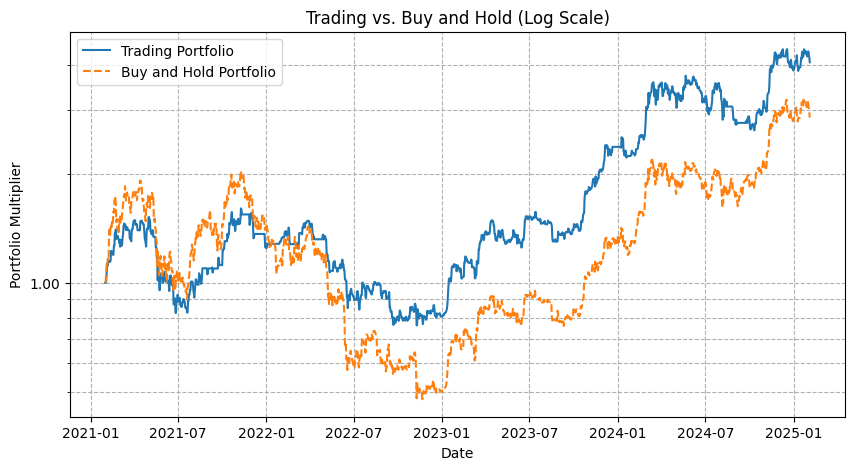

In [4]:
if __name__ == '__main__':
    # Hyperparameter
    num_episodes = 50
    batch_size = 64
    gamma = 0.99
    learning_rate = 1e-3
    buffer_capacity = 10000
    epsilon_start = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.995
    target_update_freq = 5  # Update Target-Netzwerk alle 5 Episoden
    
    window_size = 30
    # Training: 2015-01-01 bis 2020-12-31
    train_env = BitcoinTradingEnv(window_size=window_size, initial_capital=1.0,
                                  overall_start_date='2014-09-17', overall_end_date='2025-12-31',
                                  date_range=("2015-01-01", "2020-12-31"))
    
    sample_obs = train_env.reset()
    flat_sample = flatten_state(sample_obs)
    input_dim = flat_sample.shape[0]
    output_dim = train_env.action_space.n
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    q_net = QNetwork(input_dim, output_dim).to(device)
    target_net = QNetwork(input_dim, output_dim).to(device)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = optim.Adam(q_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayBuffer(buffer_capacity)
    epsilon = epsilon_start
    
    print("Training started...")
    for episode in range(num_episodes):
        state = train_env.reset()
        state_flat = flatten_state(state)
        total_reward = 0
        done = False
        while not done:
            # Epsilon-greedy Aktion
            if random.random() < epsilon:
                action = train_env.action_space.sample()
            else:
                state_tensor = torch.FloatTensor(state_flat).unsqueeze(0).to(device)
                with torch.no_grad():
                    q_values = q_net(state_tensor)
                action = int(torch.argmax(q_values, dim=1).item())
            next_state, reward, done, _ = train_env.step(action)
            next_state_flat = flatten_state(next_state)
            replay_buffer.push(state_flat, action, reward, next_state_flat, done)
            state_flat = next_state_flat
            total_reward += reward
            
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states = torch.FloatTensor(states).to(device)
                actions = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
                next_states = torch.FloatTensor(next_states).to(device)
                dones = torch.FloatTensor(dones).unsqueeze(1).to(device)
                
                q_values = q_net(states).gather(1, actions)
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
                    target = rewards + gamma * next_q_values * (1 - dones)
                loss = nn.MSELoss()(q_values, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        print(f"Episode {episode+1}/{num_episodes} - Total Reward: {total_reward:.4f} - Epsilon: {epsilon:.4f}")
        if (episode+1) % target_update_freq == 0:
            target_net.load_state_dict(q_net.state_dict())
    print("Training completed.")
    
    # Testphase: 2021-01-01 bis 2025-12-31
    test_env = BitcoinTradingEnv(window_size=window_size, initial_capital=1.0,
                                 overall_start_date='2014-09-17', overall_end_date='2025-12-31',
                                 date_range=("2021-01-01", "2025-12-31"))
    
    state = test_env.reset()
    state_flat = flatten_state(state)
    done = False
    while not done:
        state_tensor = torch.FloatTensor(state_flat).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = q_net(state_tensor)
        action = int(torch.argmax(q_values, dim=1).item())
        next_state, reward, done, _ = test_env.step(action)
        state_flat = flatten_state(next_state)
    
    test_env.plot_comparison_log()
